In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import os
import csv

In [2]:
# things we want to capture:
# tangible equity/tangible asset -> we need tangible equity and tangible asset 
# - supposed to show the banks we're interested in don't have a very high EQUITY PERCENT relative to their ASSETS
# leverage ratio, apparently this is diff than tang asset percent
# Also use total debt / total assets == leverage
# leverage ratio = tier 1 capital / total consolidated assets
# tier 1 capital = shareholders equity + retained earnings

# gonna use long term debt / short term debt ratio


list_files = os.listdir("./assetsheets")
num_files = len(list_files)
arr = []
for file in list_files:
    file_path = "./assetsheets/" + file
    total_str = ""
    if (os.path.isfile(file_path)):
        with open(file_path,encoding='utf-8') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter='\n')
            for row in csv_reader:
                x = "".join(row)
                total_str += x
    arr.append(total_str)

    
svb_coords = []
sigbank_coords =[]
dict_data = {}
for data,bank in zip(arr,list_files):
#     print(data,bank)
    try:
#         print(bank)
        equity_tang_asset = data.split("Total Shareholders\' Equity / Total Assets")[1].split("Return On Average Total Equity")[0].replace(",","")
        split_eq = equity_tang_asset.split("%")
        last_eq = split_eq[0]
        total_asset_debt = data.split("Assets - Total Growth")[1].split("Return On Average")[0].replace(",","")
        split_debt = total_asset_debt.split('%')
        last_tad = split_debt[0]
#         print(last_eq,last_tad)
        dict_data[bank] = [last_eq,last_tad]
#         print(last_eq,last_tad)
        if bank == '"SVB Financial Group**(Failed - Shutdown on Mar 10 2023)**".csv':
            svb_coords = [float(last_eq),float(last_tad)]
        elif bank == '"Signature Bank **(Failed - Shutdown on Mar 12 2023)**".csv':
            sigbank_coords = [float(last_eq),float(last_tad)]
        
            
        
    except:
        # cant find total equity / total assets
        pass
# print(dict_data)

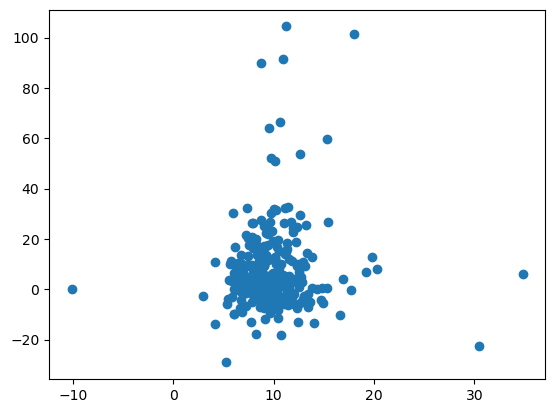

In [3]:
x = []
y = []

for value in dict_data.values():
    x.append(float(value[0]))
    y.append(float(value[1]))
plt.scatter(x,y)


In [4]:
data = pd.DataFrame(
    {'eta': x,
     'tdta': y,
    })

In [5]:
data.head(3)

,eta,tdta
0,14.33,0.03
1,11.38,-4.07
2,10.43,0.86


In [6]:
def euc_distance(pokemon1, pokemon2):
    #Do the thing
    return np.sqrt(np.sum((pokemon1-pokemon2)**2))

def jacc_distance(pokemon1, pokemon2):
    pokemon1 = set(pokemon1)
    pokemon2 = set(pokemon2)

    #Find symmetric difference of two sets
    nominator = pokemon1.symmetric_difference(pokemon2)

    #Find union of two sets
    denominator = pokemon1.union(pokemon2)

    #Take the ratio of sizes
    distance = len(nominator)/len(denominator)
    
    return distance

def jacc_euc_distance(x1, x2):
    return jacc_distance(x1[0], x2[0]) + euc_distance(x1[1:], x2[1:])

def weighted_jacc_euc_distance(pokemon1, pokemon2, a=.9): #a is the "percentage" that we'll weight Jaccard
    dist=100*(1-a)*euc_distance(x1[1:], x2[1:])+100*a*jacc_distance(x1[0], x2[0])
    return dist

In [7]:
def kmeans(df, distance, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """ 
    #preperations of data
    X = df.values
    
    # Initializing Clusters
    iterations = 0
    diff = 1
    cluster = np.zeros(X.shape[0])
    centroids = data.sample(n=k).values
    error = None
    
    while diff:
        # for each observation
        distances = np.zeros(X.shape[0])
        for i, row in enumerate(X):
            minDist = float('inf')
            # dist of the point from all centroids
            for idx, centroid in enumerate(centroids):
                d = distance(centroid, row)
                # store closest centroid
                if minDist > d:
                    minDist = d
                    distances[i] = minDist
                    cluster[i] = idx
        
        #calculate reconstruction error
        newError = np.sum(distances) 
        centroids = pd.DataFrame(X).groupby(by=cluster).mean().values


        if iterations>1:
             if error - newError <=tol:
                diff = 0
        
        error = newError
                
        iterations +=1

    #print("iterations", iterations)
    return centroids, cluster, error

### Elbow Graph

In [8]:
#process data
X = data.values

results = []
x = [] 
for i in range(10):
    centroids, cluster, error = None, None, None
    minError = float('inf')

    for j in range(20):
        #calculate K-Means
        c1, c2, e = kmeans(data, euc_distance, k=i+1)
        if e < minError: 
            centroids, cluster, error = c1, c2, e
            #print('error', error)

    
    results.append(error)
    x.append(i+1)

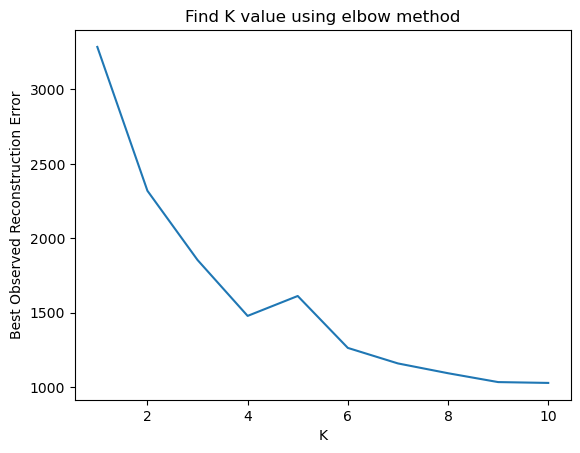

In [9]:
plt.plot(x, results)
plt.title('Find K value using elbow method')
plt.xlabel('K')
plt.ylabel('Best Observed Reconstruction Error')
plt.show()

error 1545.054305067262


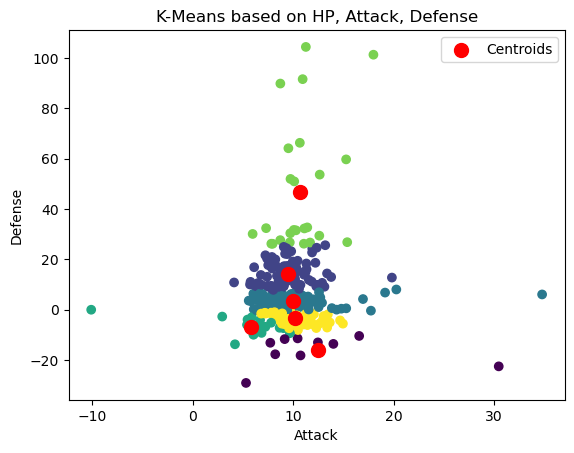

In [10]:
#process data
X = data.values

centroids, cluster, error = None, None, None
minError = float('inf')

for i in range(20):
    #calculate K-Means
    c1, c2, e = kmeans(data, euc_distance, k=6)
    if e < minError: 
        centroids, cluster, error = c1, c2, e
    
#plot data
print('error', error)
plt.scatter(X[:,0],X[:,1], c=cluster)
plt.scatter(centroids[:,0],centroids[:,1], s=100, color='r', label='Centroids')
plt.title('K-Means based on HP, Attack, Defense')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.legend()
plt.show()